In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The data used for this task is the MovieLens data set. 

In [ ]:
link = pd.read_csv('/content/drive/My Drive/Colab Notebooks/links.csv')
ratings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ratings.csv')
movies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/movies.csv')
tags = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tags.csv')

Displaying all files data

In [ ]:
print("                 LINKS")
print(link.tail())
print("\n                 RATINGS")
print(ratings.head())
print("\n                 MOVIES")
print(movies.head())
print("\n                 TAGS")
print(tags.head())

                 LINKS
      movieId   imdbId    tmdbId
9737   193581  5476944  432131.0
9738   193583  5914996  445030.0
9739   193585  6397426  479308.0
9740   193587  8391976  483455.0
9741   193609   101726   37891.0

                 RATINGS
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

                 MOVIES
   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]

                 TAGS
   userId  movieId              tag   timestamp
0       2    60756            funny  1445

#Part I: ML Method for Recommendations

In [ ]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

**Recommendation for NEW USER**

Recommending top rated movies to a new user based on all the existing ratings for the movie

In [ ]:
df = ratings.groupby('movieId').agg({'timestamp':'size', 'rating':'mean'}).rename(columns={'timestamp':'review_count','rating':'mean_rating'}).reset_index()
df = df[df['review_count']>25].sort_values('mean_rating',ascending=False)

final = pd.merge(df,movies, on='movieId', how='inner')
final.head()

,movieId,review_count,mean_rating,title,genres
0,318,317,4.429022,"Shawshank Redemption, The (1994)",Crime|Drama
1,922,27,4.333333,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
2,898,29,4.310345,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
3,1204,45,4.300000,Lawrence of Arabia (1962),Adventure|Drama|War
4,246,29,4.293103,Hoop Dreams (1994),Documentary


5 movies recommended for a new user based on **ratings**.

In [ ]:
print("Top 5 recommendations for a new user based on ratings are:")
for i in range(5):
  print(final['title'][i],final['mean_rating'][i])

Top 5 recommendations for a new user based on ratings are:
Shawshank Redemption, The (1994) 4.429022082018927
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) 4.333333333333333
Philadelphia Story, The (1940) 4.310344827586207
Lawrence of Arabia (1962) 4.3
Hoop Dreams (1994) 4.293103448275862


Top 5 recommendations based on **genre** for a new user

In [ ]:
genre = 'Comedy'

movie_genre = pd.merge(movies,final, on='movieId', how='inner')
movie_genre=movie_genre[['movieId','title_x', 'genres_x','mean_rating']].rename(columns={'genres_x' : 'genres', 'title_x':'title'})
movie_genre=movie_genre.assign(genres=movie_genre['genres'].str.split('|')).explode('genres')

movie_genre["rank"] = movie_genre.groupby("genres")["mean_rating"].rank("dense", ascending=False)
              
movie_genre= movie_genre[(movie_genre['genres']== genre) & (movie_genre['rank'] < 6)].sort_values('rank').reset_index()
movie_genre


,index,movieId,title,genres,mean_rating,rank
0,197,898,"Philadelphia Story, The (1940)",Comedy,4.310345,1.0
1,279,1235,Harold and Maude (1971),Comedy,4.288462,2.0
2,179,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy,4.268041,3.0
3,255,1197,"Princess Bride, The (1987)",Comedy,4.232394,4.0
4,83,296,Pulp Fiction (1994),Comedy,4.197068,5.0


In [ ]:
print("Top 5 recommendations for a new user in the "+ genre + " genre are:")
for i in range(5):
  print(str(i+1)+". "+movie_genre['title'][i],"with rating "+str(movie_genre['mean_rating'][i]))

Top 5 recommendations for a new user in the Comedy genre are:
1. Philadelphia Story, The (1940) with rating 4.310344827586207
2. Harold and Maude (1971) with rating 4.288461538461538
3. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) with rating 4.268041237113402
4. Princess Bride, The (1987) with rating 4.232394366197183
5. Pulp Fiction (1994) with rating 4.197068403908795


A new user has no user information. Collaborative filtering is not possible. Hence we recommend the user popular items based on some criteria (like reviews, type etc). In our case, we have recommended movies with the highest ratings. We have also recommended movies based on genre. For a genre, the movies with the highest ratings are recommended.


In [ ]:
df_inner = pd.merge(ratings, df, on='movieId', how='inner')
df_inner.head()

,userId,movieId,rating,timestamp,review_count,mean_rating
0,1,1,4.0,964982703,215,3.92093
1,5,1,4.0,847434962,215,3.92093
2,7,1,4.5,1106635946,215,3.92093
3,15,1,2.5,1510577970,215,3.92093
4,17,1,4.5,1305696483,215,3.92093


Since all movies do not have ratings from all the users, the matrix is sparse. Hence we tranform it to Compressed Sparse Row matrix. This basically gives the position of all the non zero elements. All the null values are filled with 0. It can be filled with any value as our focus is to see how similar two movies are for recommendation but not predict the rating of the film as such.

**Recommendation for EXISTING USER**

**Approach 1:**
Take user id as input. Check for most similar users based on their movie ratings. Recommend the 5 top rated movies as per the most similar user.

In [ ]:
from scipy.sparse import csr_matrix

movie_features = df_inner.pivot_table(index='userId',columns='movieId',values='rating').fillna(0)
movie_features_sparse = csr_matrix(movie_features.values)

New recommendations are given to an existing user by using the KNN algorithm. 
The similarity measure is cosine and the distance metric is Euclidean. The algorithm to find distance between points is ‘auto’. It will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=15)
model_knn.fit(movie_features_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [ ]:
userid = 100
test_user = movie_features.iloc[userid-1]
test_user = np.array(test_user).reshape(1,-1)
movie_features.iloc[userid-1]

movieId
1         0.0
2         0.0
3         3.5
5         0.0
6         0.0
         ... 
139385    0.0
148626    0.0
152081    0.0
164179    0.0
166528    0.0
Name: 100, Length: 1012, dtype: float64

In [ ]:
distances,indices = model_knn.kneighbors(test_user, n_neighbors = 15)

In [ ]:
rec_movies = pd.DataFrame()
rec_movies['rating']= movie_features.iloc[indices[0][1]-1].nlargest()
rec_movies = pd.merge(rec_movies,movies, on='movieId', how='inner')
rec_movies


,movieId,rating,title,genres
0,543,5.0,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller
1,720,5.0,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
2,745,5.0,Wallace & Gromit: A Close Shave (1995),Animation|Children|Comedy
3,912,5.0,Casablanca (1942),Drama|Romance
4,1080,5.0,Monty Python's Life of Brian (1979),Comedy


In [ ]:
print("Top 5 recommendations for an user 100 based on most similar user and their top rated movies:")
for i in range(5):
  print(str(i+1)+". "+rec_movies['title'][i],"with rating "+str(rec_movies['rating'][i]))

Top 5 recommendations for an user 100 based on most similar user and their top rated movies:
1. So I Married an Axe Murderer (1993) with rating 5.0
2. Wallace & Gromit: The Best of Aardman Animation (1996) with rating 5.0
3. Wallace & Gromit: A Close Shave (1995) with rating 5.0
4. Casablanca (1942) with rating 5.0
5. Monty Python's Life of Brian (1979) with rating 5.0


**Approach 2:**
Take a movie id as input. Check for similar movies based on KNN using user ratings and recommend the top 5 most similar movies.

In [ ]:
from scipy.sparse import csr_matrix

movie_features = df_inner.pivot_table(index='movieId',columns='userId',values='rating').fillna(0)
movie_features_sparse = csr_matrix(movie_features.values)

New recommendations are given to an existing user by using the KNN algorithm. 
The similarity measure is cosine and the distance metric is Euclidean. The algorithm to find distance between points is ‘auto’. It will attempt to decide the most appropriate algorithm based on the values passed to fit method.

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=15)
model_knn.fit(movie_features_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [ ]:
userid = 100
test_user = movie_features.iloc[userid-1]
test_user = np.array(test_user).reshape(1,-1)

In [ ]:
distances,indices = model_knn.kneighbors(test_user, n_neighbors = 15)

In [ ]:
print("Top 10 recommendations for " + movies.loc[movie_features.index[350]][1])

for i in range(10): 
    print(movies.loc[movie_features.index[indices[0][i]]][1])

Top 10 recommendations for Rescuers Down Under, The (1990)
Street Fighter (1994)
Safe (1995)
Romper Stomper (1992)
RoboCop 3 (1993)
Much Ado About Nothing (1993)
Color of Night (1994)
Vanya on 42nd Street (1994)
Cold Comfort Farm (1995)
Something to Talk About (1995)
American President, The (1995)


#Part II: Deep Learning Methods for Recommendations



In [ ]:
max_userid = ratings['userId'].nunique()+1
max_movieid = ratings['movieId'].drop_duplicates().max()+1


Preparing the data for training. 

In [ ]:

randomized_ratings = ratings.sample(frac=1, random_state=100)

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Concatenate, Add, Dot, Input, Dropout, Dense, Activation
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam

user_shape = Input(shape=(1,))
u_embvec = Embedding(max_userid, 100)(user_shape)
u_embvec = Reshape((100,))(u_embvec)

movie_shape = Input(shape=(1,))
m_embvec = Embedding(max_movieid, 100)(movie_shape)
m_embvec = Reshape((100,))(m_embvec)

x = Concatenate()([u_embvec, m_embvec])

x = Dense(10)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(1)(x)
x = Activation('linear')(x)

model = Model(inputs=[user_shape, movie_shape], outputs=x)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       61100       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       19361000    input_2[0][0]                    
_______________________________________________________________________________________

In [ ]:
history = model.fit([randomized_ratings['userId'], randomized_ratings['movieId']], randomized_ratings['rating'], batch_size=128, epochs=5, verbose=1, validation_split=0.1)

Epoch 1/5
709/709 [==============================] - 126s 177ms/step - loss: 3.6004 - val_loss: 1.0647
Epoch 2/5
709/709 [==============================] - 125s 177ms/step - loss: 2.1423 - val_loss: 0.9731
Epoch 3/5
709/709 [==============================] - 126s 177ms/step - loss: 1.7699 - val_loss: 0.8967
Epoch 4/5
709/709 [==============================] - 125s 177ms/step - loss: 1.4418 - val_loss: 0.8683
Epoch 5/5
709/709 [==============================] - 125s 176ms/step - loss: 1.1756 - val_loss: 0.7991


While recommending new movies to a user, we need to recommend only those movies which the user has not seen yet. So, we are collecting a list of all the movies the user has not seen yet.

In [ ]:
userid =100
watched_movies = ratings[ratings['userId'] == userid]
unwatched_movies=pd.concat([movies['movieId'],watched_movies['movieId']]).drop_duplicates(keep=False)
unwatched_movies.values

array([     1,      2,      4, ..., 193585, 193587, 193609])

Predicting the rating for all the movies a particular user has watched.

In [ ]:

l = [None] * len(unwatched_movies.values)
for i in range(len(unwatched_movies.values)):
  l[i]=model.__call__([np.array([userid]), np.array([unwatched_movies.values[i]])])[0][0]


model.__call__ gave much faster results as compared to model.predict. 
Code for predict method is as follows:
##### l=[]
##### for i in unwatched_movies.values:
#####   l.append(model.predict([np.array([userid]), np.array([i])])[0][0])

__call__ can be used for a smaller input size. 
model.predict took around 430 seconds to predict on the entire input set while model.__call__ took 49 seconds.

In [ ]:
df_final = pd.DataFrame()
df_final['movie'] = unwatched_movies
df_final['predicted_rating'] = l


In [ ]:
df_final.sort_values('predicted_rating',ascending=False,inplace=True)

In [ ]:
print("Top 10 recommendations for user : " + str(userid))

for i in range(0,10,1):
    print(movies[movies['movieId'] == df_final['movie'].values[i]]['title'].values[0] + " with predicted rating " + str("%.2f" % df_final['predicted_rating'].values[i]))

Top 10 recommendations for user : 100
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997) with predicted rating 4.88
Piper (2016) with predicted rating 4.62
Afterglow (1997) with predicted rating 4.60
Rififi (Du rififi chez les hommes) (1955) with predicted rating 4.59
No Direction Home: Bob Dylan (2005) with predicted rating 4.56
Baby Driver (2017) with predicted rating 4.56
Adam's Rib (1949) with predicted rating 4.55
Three Billboards Outside Ebbing, Missouri (2017) with predicted rating 4.54
Come and See (Idi i smotri) (1985) with predicted rating 4.53
Day of the Doctor, The (2013) with predicted rating 4.52


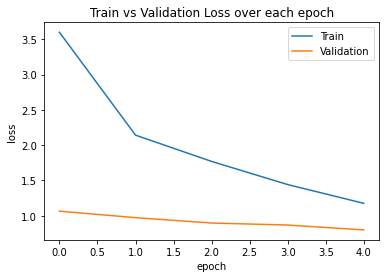

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss over each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='best')

For part 1, KNN, we take consider the different user ratings given to a movie and see how similar a movie is to another movie based on the cosine similarity. In this way, we see the most similar movies to the given input and recommend these to the user.

For part 2, deep learning approach, we predict the rating for a user and movie id. If we predict as per the user, we get an idea on what kind of recommendations to give to this user. As this predicts the ratings the user would give to the movies they have not seen yet. In this process, we recommend movies with the highest predicted rating. We use embeddings to represent each user and each movie in the data. These embeddings will be vectors that are initially random numbers but are later fit by the model to capture the important qualities of each user and movie id.

The recommendations from both the ML and the deep learning methods might be different as the basis of recommendation of both these approaches is different. ML method recommends movies based on user and movie similarity and the Deep Learning approach recommends movies based on regression, that is, by predicting the ratings by a user for a movie.

## REFERENCES
1. https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/
2. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
3. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors